# DBSCAN

## Setup

In [40]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# Scikit-learn
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

## Prepare the data

In [4]:
x, y, c = make_blobs(
    n_samples=1000,
    centers=4,
    n_features=2,
    random_state=1992,
    cluster_std=0.8,
    return_centers=True,
)

df_blobs = pl.DataFrame(
    {
        "x1": x[:, 0],
        "x2": x[:, 1],
    }
)

df_centers = pl.DataFrame(
    {
        "x1": c[:, 0],
        "x2": c[:, 1],
    }
)

In [6]:
x_m, y_m = make_moons(n_samples=500, noise=0.05, random_state=1992)

df_moons = pl.DataFrame(
    {
        "x1": x_m[:, 0],
        "x2": x_m[:, 1],
    }
)

## Visualize the blobs

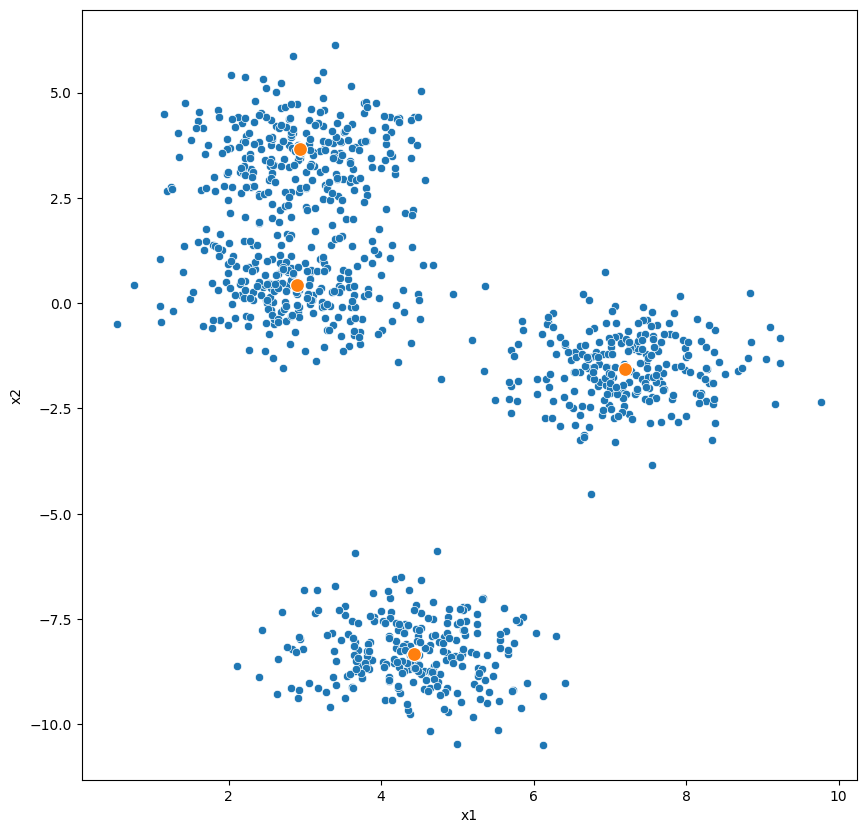

In [8]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_blobs, x="x1", y="x2")
sns.scatterplot(data=df_centers, x="x1", y="x2", markers="X", s=100)
plt.plot()
plt.show()

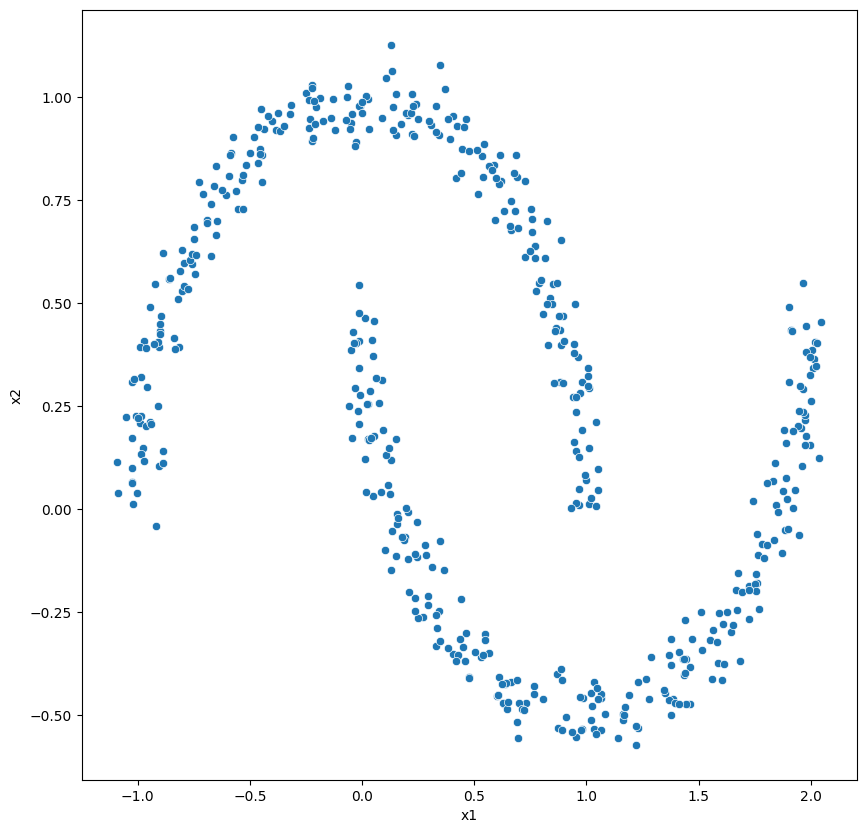

In [10]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_moons, x="x1", y="x2")
plt.show()

## Implementing DBSCAN

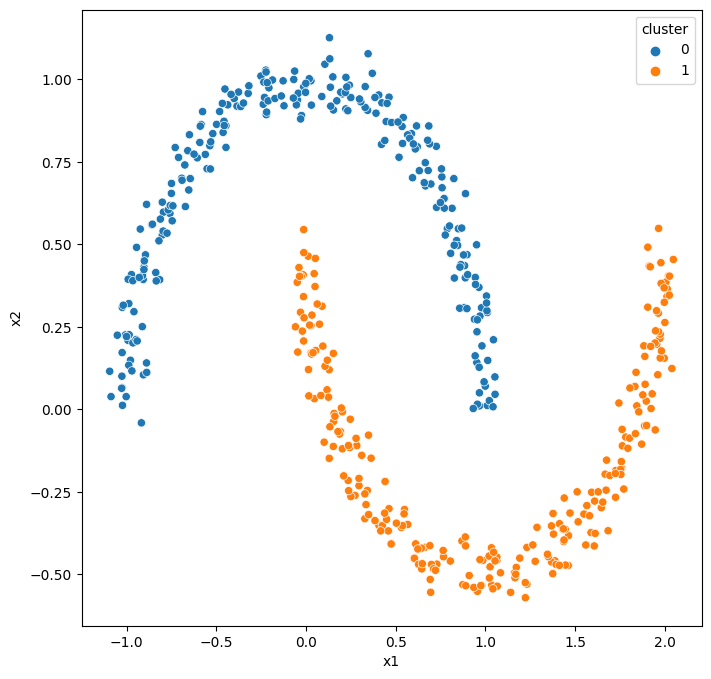

In [15]:
dbscan_cluster = DBSCAN(eps=0.3, min_samples=5)
y_m_pred = dbscan_cluster.fit_predict(x_m) 
df_moons = df_moons.with_columns(pl.Series(values=y_m_pred, name="cluster"))

plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_moons, x="x1", y="x2", hue="cluster")
plt.show()

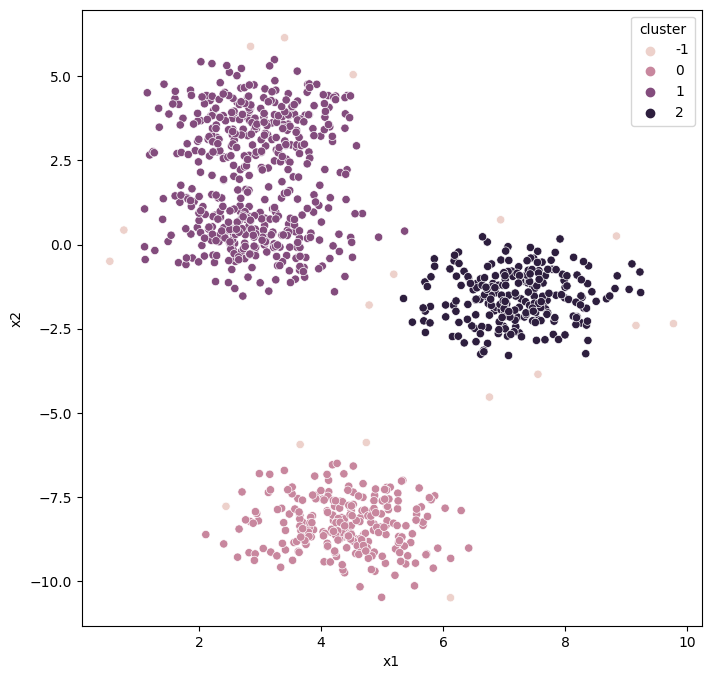

In [20]:
dbscan_cluster = DBSCAN(eps=0.5, min_samples=3)
y_pred = dbscan_cluster.fit_predict(x)
df_blobs = df_blobs.with_columns(pl.Series(values=y_pred, name="cluster"))

plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_blobs, x="x1", y="x2", hue="cluster")
plt.show()

## Finding best hyperparameters for DBSCAN

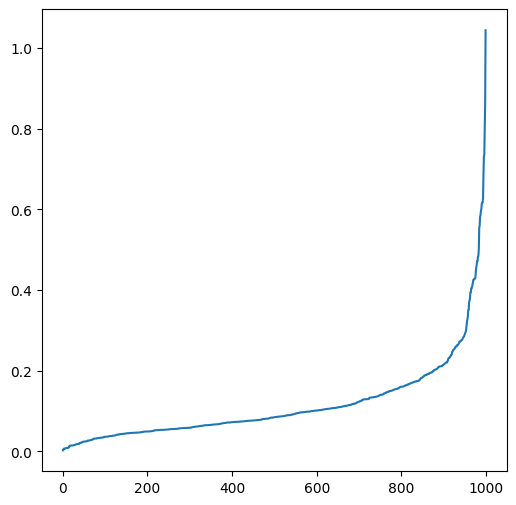

In [30]:
x_neighbors = NearestNeighbors(n_neighbors=3).fit(x)
distances, indices = x_neighbors.kneighbors(x)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

plt.figure(figsize=(6, 6))
plt.plot(distances, label="DBSCAN")

In [32]:
eps_values = np.arange(0.25, 0.8, 0.1)
min_samples = np.arange(2, 10, 1)

dbscan_params = list(product(eps_values, min_samples)) 
sil_scores = []
for params in dbscan_params:
    eps, min_samples = params
    y_pred = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(x)
    sil_scores.append(silhouette_score(x, y_pred))

In [35]:
df_params_tuning = pl.from_records(dbscan_params, schema=["eps", "min_samples"])
df_params_tuning = df_params_tuning.with_columns(pl.Series(values=sil_scores, name="sil_scores"))
df_params_tuning.head()

eps,min_samples,sil_scores
f64,i64,f64
0.25,2,-0.16997
0.25,3,-0.099316
0.25,4,-0.036283
0.25,5,-0.087467
0.25,6,-0.060013


In [41]:
pivot_data = pd.pivot_table(
    data=df_params_tuning.to_pandas(),
    index="min_samples",
    columns="eps",
    values="sil_scores",
)
pivot_data

eps,0.25,0.35,0.45,0.55,0.65,0.75
min_samples,,,,,,
2,-0.169970,-0.079764,0.511390,0.648525,0.560115,0.348222
3,-0.099316,0.112968,0.529003,0.648525,0.626795,0.407208
4,-0.036283,0.115740,0.637341,0.648525,0.643982,0.619711
5,-0.087467,0.095885,0.634741,0.643558,0.643447,0.619711
6,-0.060013,0.418151,0.629755,0.649098,0.647226,0.619711
7,-0.145665,0.402223,0.615446,0.645790,0.651692,0.620202
8,-0.120520,0.366189,0.604418,0.639411,0.649653,0.651955
9,-0.079862,0.448014,0.581374,0.634553,0.649653,0.654950


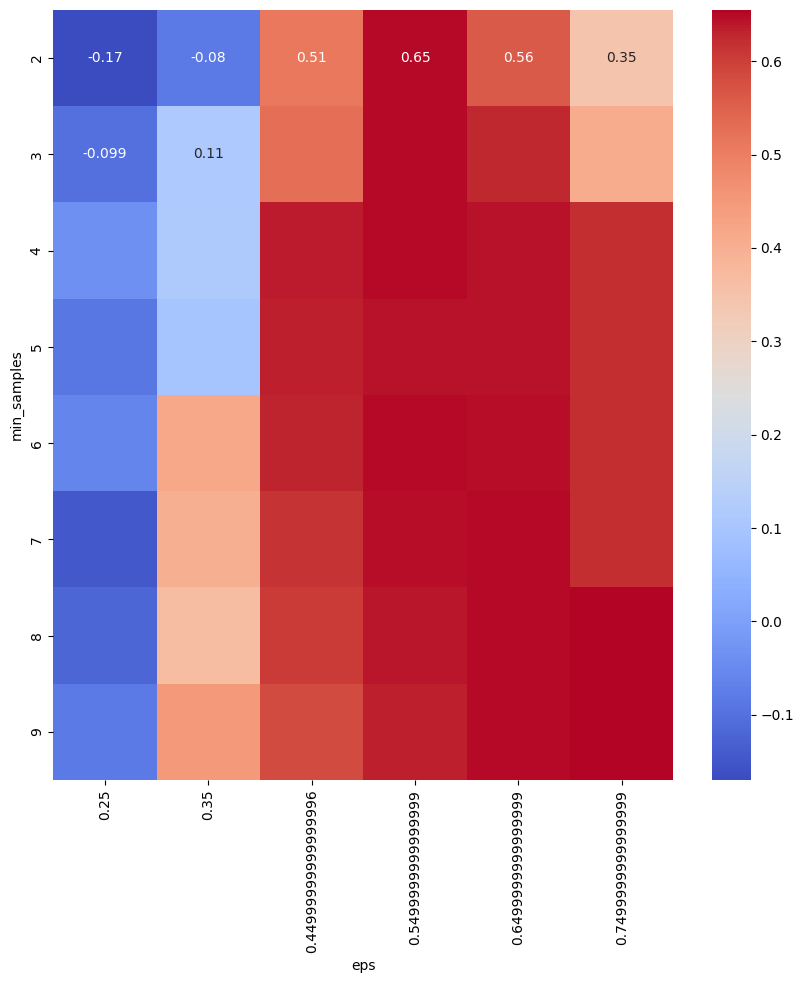

In [42]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(pivot_data, annot=True, annot_kws={"size": 10}, cmap="coolwarm", ax=ax)
plt.show()

## DBSCAN Evaluation

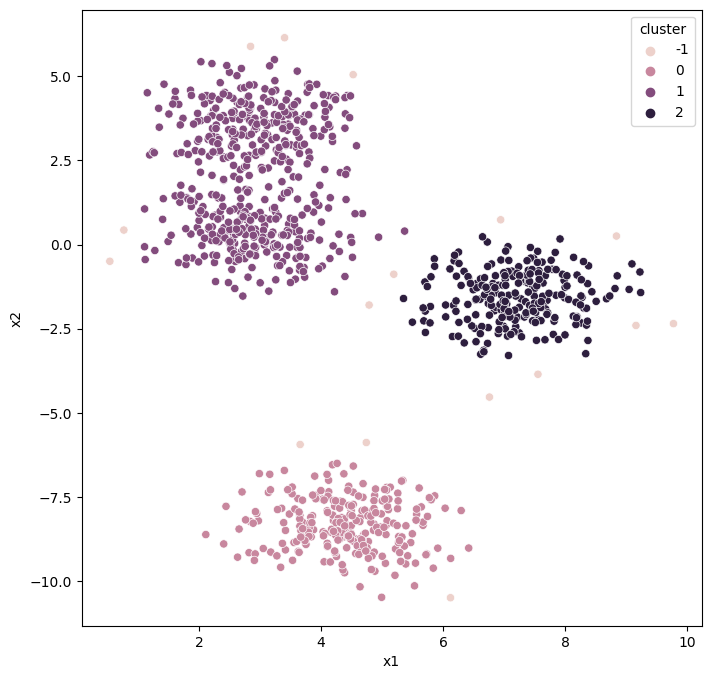

In [43]:
dbscan_clusterer = DBSCAN(eps=0.55, min_samples=2)
y_preds = dbscan_clusterer.fit_predict(x)
df_blobs = df_blobs.with_columns(pl.Series(values=y_preds, name="cluster")) 

# Plot the data
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_blobs, x="x1", y="x2", hue="cluster")
plt.plot()
plt.show()

For n_clusters = 4 The average silhouette_score is : 0.6485251960720841


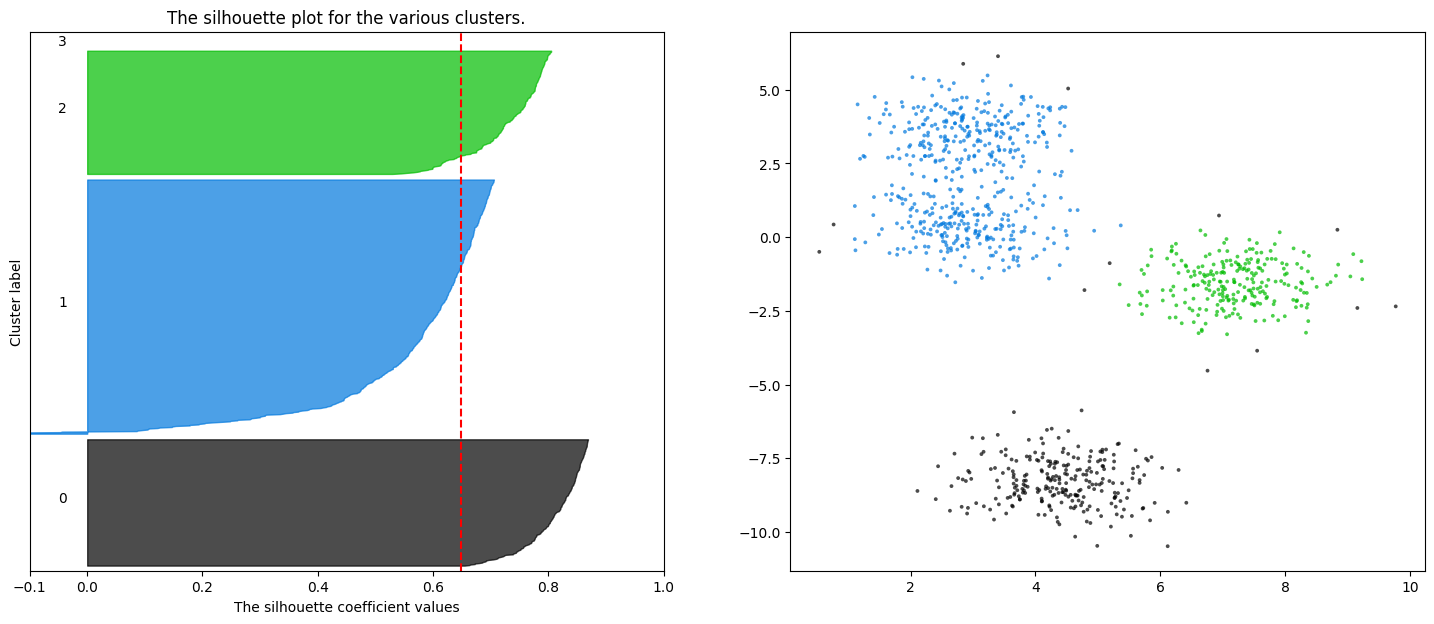

In [46]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = DBSCAN(eps=0.55, min_samples=3)
cluster_labels = clusterer.fit_predict(x)
n_clusters = np.unique(cluster_labels).shape[0]

# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(x) + (n_clusters + 1) * 10])


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(x, cluster_labels)
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(x, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(
    x[:, 0], x[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

plt.show()